# Test Subset
___

## Setup

### Importing Packages

In [1]:
import os
import shutil
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from astronomaly.dimensionality_reduction import pca
import seaborn as sns
import matplotlib.pyplot as plt

### Directories

In [2]:
# Data Root Directory
data_root_dir = os.path.join(os.getcwd(), 'Data')

# Label Directory
label_dir = os.path.join(data_root_dir, 'DeCaLs/gz_decals_volunteers_1_and_2.parquet')

# Image Directory
img_dir = os.path.join(data_root_dir, 'DeCaLs')

# Feature Directory
feature_dir = os.path.join(data_root_dir, 'features.parquet')

# Cluster Assignment Directory
cluster_prob_dir = os.path.join(data_root_dir, 'cluster_with_prob.parquet')

# Output Directory
output_root_dir = os.path.join(data_root_dir, 'Output')

# Classification Directories
spiral_dir = os.path.join(output_root_dir, 'spirals')
round_ell_dir = os.path.join(output_root_dir, 'round_ellipticals')
edge_on_dir = os.path.join(output_root_dir, 'edge_on')

### Cluster Probabilities

In [3]:
cluster_prob = pd.read_parquet(cluster_prob_dir)
print('Cluster Probablities: ', cluster_prob.shape)

Cluster Probablities:  (230575, 21)


### Features

In [4]:
features = pd.read_parquet(feature_dir)
print('Features with Cluster No.: ', features.shape)

Features with Cluster No.:  (230575, 512)


In [8]:
feat_clust_prob = pd.concat([cluster_prob, features], axis=1)
print('Cluster Assignment with Probabilities and Features: ', feat_clust_prob.shape)

Cluster Assignment with Probabilities and Features:  (230575, 533)


### Volunteer Labels

In [9]:
volunteer_labels = pd.read_parquet(label_dir)
volunteer_labels = volunteer_labels.set_index('iauname')
print('Volunteer Labels: ', volunteer_labels.shape)

Volunteer Labels:  (92960, 114)


### Filtering

In [25]:
common_labels = volunteer_labels.index.intersection(feat_clust_prob.index)
filtered_volunteer_labels = volunteer_labels.loc[common_labels]
filtered_volunteer_labels.index.name= 'iauname'
filtered_feat_clust_prob = feat_clust_prob.loc[common_labels]
filtered_data = pd.concat([filtered_feat_clust_prob, filtered_volunteer_labels], axis=1)
print('Filtered Cluster Assignment with Probabilities and Features: ', filtered_feat_clust_prob.shape)
print('Filtered Volunteer Labels: ', filtered_volunteer_labels.shape)
print('Filtered Data: ', filtered_data.shape)

Filtered Cluster Assignment with Probabilities and Features:  (65290, 533)
Filtered Volunteer Labels:  (65290, 114)
Filtered Data:  (65290, 647)


## Galaxy Assignment

In [26]:
count = 0
filenames_to_find = set(filtered_volunteer_labels.index.astype(str) + '.png')

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            count +=1
print('No. of labelled images: ', count)

No. of labelled images:  65290


In [27]:
columns = [col for col in filtered_volunteer_labels.columns if 'edge' in col]
for col in columns:
    print(col)

disk-edge-on_total-votes
disk-edge-on_yes
disk-edge-on_yes_fraction
disk-edge-on_yes_debiased
disk-edge-on_no
disk-edge-on_no_fraction
disk-edge-on_no_debiased
edge-on-bulge_total-votes
edge-on-bulge_rounded
edge-on-bulge_rounded_fraction
edge-on-bulge_rounded_debiased
edge-on-bulge_boxy
edge-on-bulge_boxy_fraction
edge-on-bulge_boxy_debiased
edge-on-bulge_none
edge-on-bulge_none_fraction
edge-on-bulge_none_debiased


### Edge-on Galaxies

In [35]:
edge_on_gal = filtered_data[(filtered_data['disk-edge-on_total-votes'] >= 5) &
                                        (filtered_data['disk-edge-on_yes_fraction'] > 0.8) &
                                        (filtered_data['merging_total-votes'] >= 10) &
                                        (filtered_data['merging_merger_fraction'] < 0.2)].copy()
edge_on_gal['Type'] = 'E'

In [36]:
filenames_to_find = set(edge_on_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(edge_on_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

5421


### Round Elliptical Galaxies

In [37]:
round_ell_gal = filtered_data[(filtered_data['smooth-or-featured_smooth_fraction'] > 0.8) &
                                          (filtered_data['how-rounded_total-votes'] >= 5) &
                                          (filtered_data['how-rounded_completely_fraction'] > 0.8) &
                                          (filtered_data['merging_total-votes'] >= 10) &
                                          (filtered_data['merging_merger_fraction'] < 0.2)].copy()
round_ell_gal['Type'] = 'R'

In [38]:
filenames_to_find = set(round_ell_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(round_ell_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

4231


### Spiral Galaxies

In [39]:
spiral_gal = filtered_data[(filtered_data['smooth-or-featured_featured-or-disk_fraction'] > 0.8) &
                                       (filtered_data['has-spiral-arms_total-votes'] >= 5) &
                                       (filtered_data['has-spiral-arms_yes_fraction'] > 0.8) &
                                       (filtered_data['merging_total-votes'] >= 10) &
                                       (filtered_data['merging_merger_fraction'] < 0.2)].copy()
spiral_gal['Type'] = 'S'

In [40]:
filenames_to_find = set(spiral_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(spiral_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

4034


In [41]:
# save cluster index to label dataframe
test_subset = pd.concat([spiral_gal, round_ell_gal, edge_on_gal])
print('Test Subset: ', test_subset.shape)

Test Subset:  (13686, 648)


### Plotting

<Axes: xlabel='Cluster', ylabel='smooth-or-featured_featured-or-disk_fraction'>

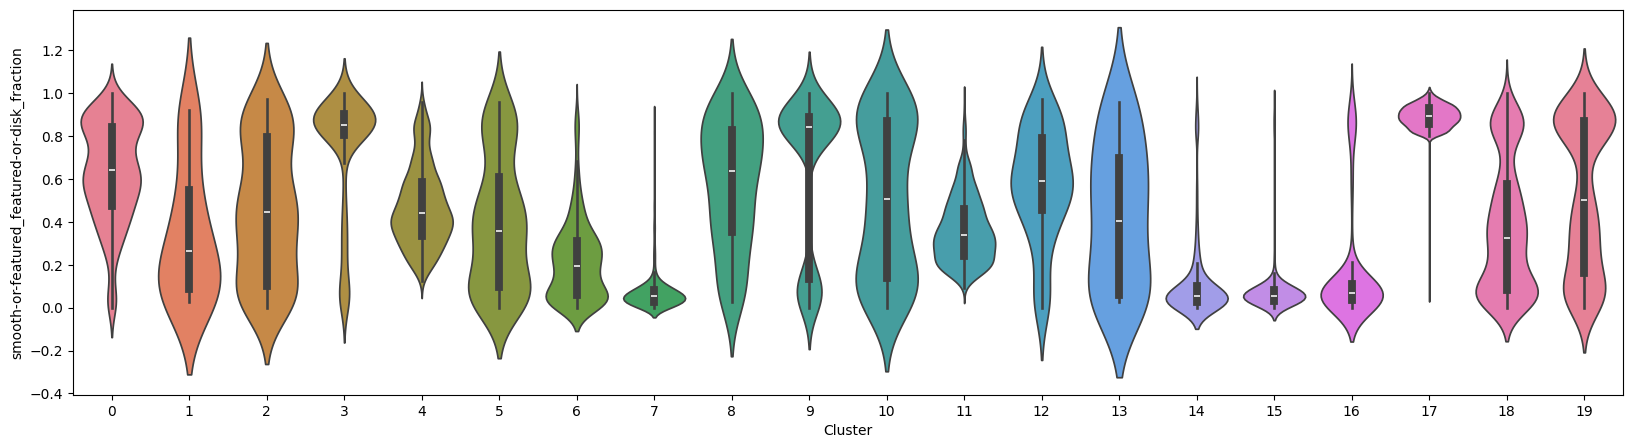

In [42]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='smooth-or-featured_featured-or-disk_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='how-rounded_cigar-shaped_fraction'>

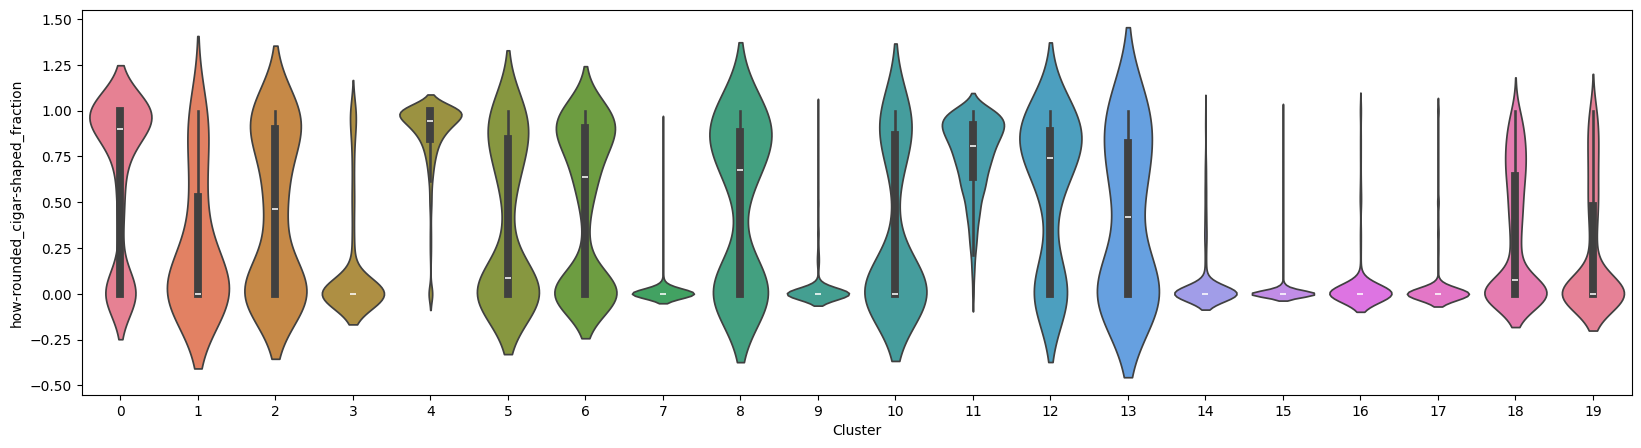

In [43]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='how-rounded_cigar-shaped_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='disk-edge-on_yes_fraction'>

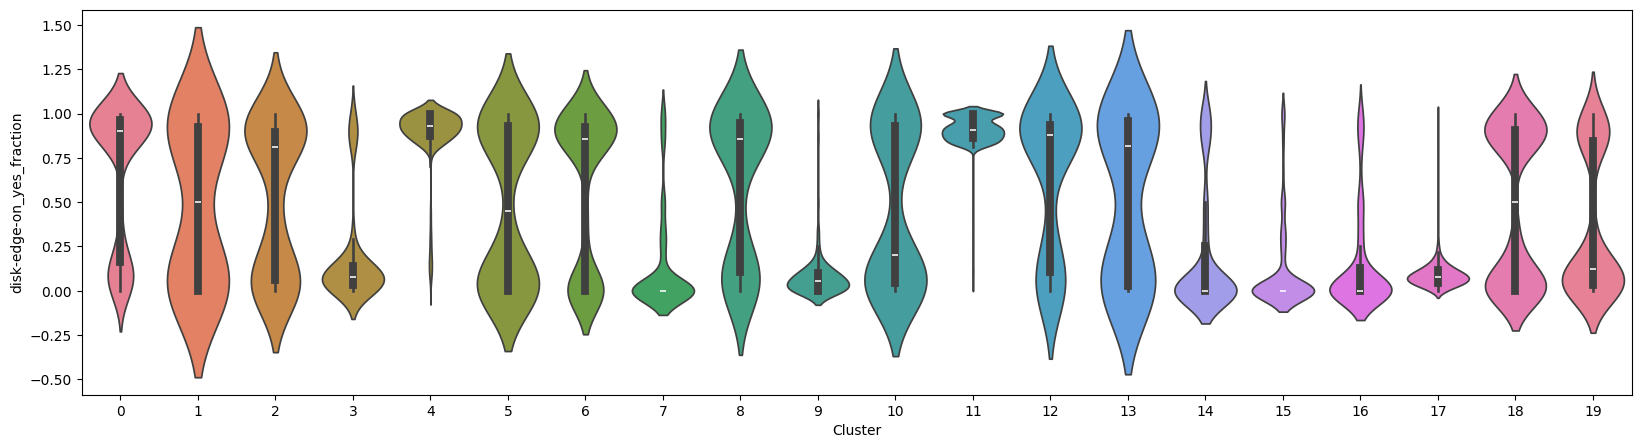

In [44]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='disk-edge-on_yes_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='bulge-size_dominant_fraction'>

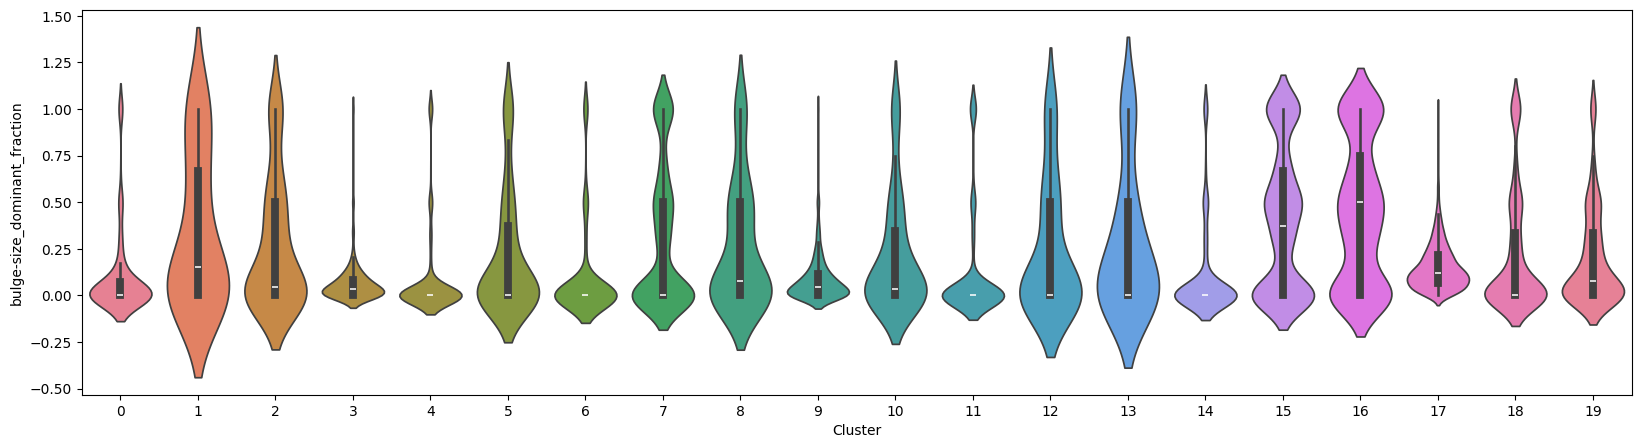

In [45]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='bulge-size_dominant_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='merging_neither_fraction'>

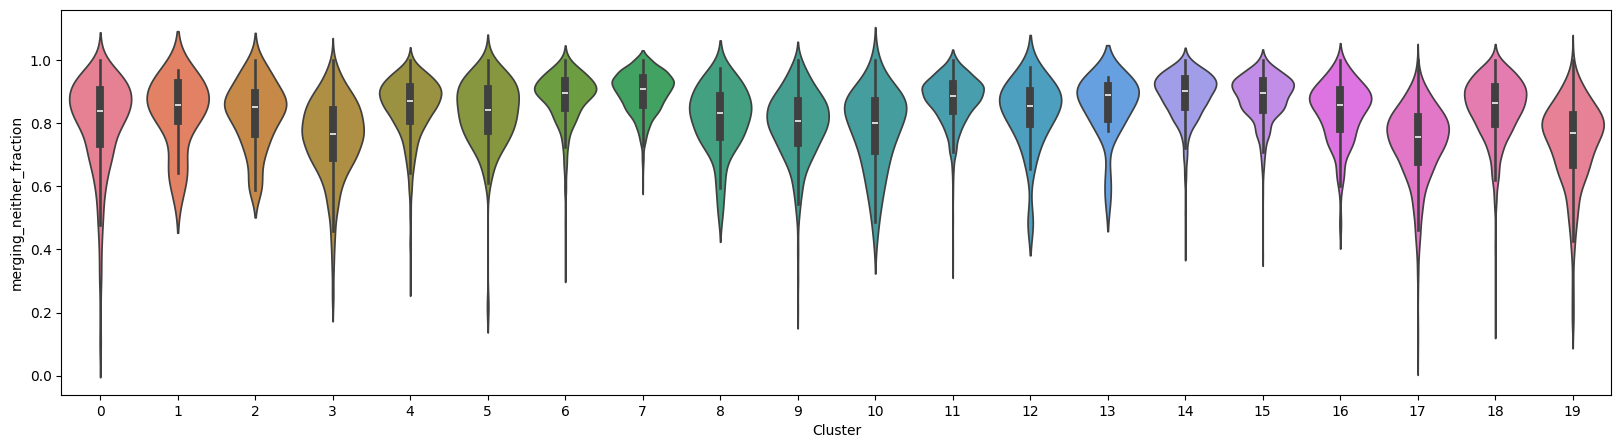

In [46]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='merging_neither_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

## Cluster Assignment

In [47]:
counts = test_subset.groupby(['Cluster', 'Type']).size()
counts_df = counts.reset_index(name='Count')
counts_df['Total'] = counts_df.groupby('Cluster')['Count'].transform('sum')
counts_df['Percentage'] = counts_df['Count'] / counts_df['Total'] * 100
dominant = counts_df.loc[counts_df.groupby('Cluster')['Count'].idxmax()]

cluster_df = dominant.set_index('Cluster')[['Type', 'Percentage']]
cluster_df.columns = ['Dominant_Type', 'Percentage']
cluster_df['Percentage'] = cluster_df['Percentage'].round(2)

print(cluster_df)

        Dominant_Type  Percentage
Cluster                          
0                   E       67.76
1                   E       42.86
2                   E       51.85
3                   S       76.64
4                   E       93.81
5                   E       48.28
6                   E       60.60
7                   R       93.57
8                   E       59.09
9                   S       71.27
10                  E       41.89
11                  E       99.11
12                  E       65.91
13                  E       48.00
14                  R       81.89
15                  R       95.70
16                  R       83.17
17                  S       98.97
18                  E       48.20
19                  S       43.17
